## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
jax.config.update("jax_disable_jit", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import pickle

In [2]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
#df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Discretize each column

Current setup:
* delta tokens
* n_bins = 256
* quantile-based bins (centered at 0)

In [3]:
# Z-norm standardisation
#X['Power demand'] = np.log1p(X['Power demand'])
mu = X.mean(axis=0)
sigma = X.std(axis=0) + 1e-8

X_normalized = (X-mu)/sigma
X_normalized = X_normalized.diff().dropna()
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [4]:
# fit bins
n_bins=256

#edges, mids = discretize.fit_quantile_bins_global(X_nv, n_bins=n_bins)
edges, mids = discretize.fit_equal_width_bins_global(X_nv, n_bins=n_bins)

# encode
#X_tok = discretize.encode_quantile_global(jnp.asarray(X_nv), edges)
X_tok = discretize.encode_equal_width_global(jnp.asarray(X_nv), edges)

# decode
#X_rec = discretize.decode_quantile_global(X_tok, mids)
X_rec = discretize.decode_equal_width_global(X_tok, mids)

ZERO_BIN = int(np.argmin(np.abs(mids)))
#or
assert(ZERO_BIN == discretize.encode_equal_width_global(jnp.asarray([0]), edges))

print("Zero midpoint:", mids[ZERO_BIN])
print("Index:", ZERO_BIN)


Zero midpoint: -0.0064048767
Index: 128


In [5]:
X_normalized

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
1,-0.137114,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,-0.112688,-0.061602,-0.089990,-0.041230,0.000000,0.00000,0.152233
3,-0.047263,-0.061602,0.006922,0.144305,0.000000,0.00000,0.000000
4,0.055827,-0.061602,0.027689,0.185536,0.000000,0.00000,-0.152233
5,0.251982,-0.147844,-0.256124,-0.185536,0.000000,0.00000,0.173980
...,...,...,...,...,...,...,...
27663,-0.089561,-0.061602,-0.207668,-0.082460,0.045609,-0.16581,-0.072492
27664,-0.018132,-0.012320,-0.283813,-0.164921,0.000000,-0.16581,-0.065243
27665,0.114572,-0.061602,0.083067,0.082460,-0.045609,0.00000,-0.014498
27666,0.146685,-0.123203,0.089990,0.123690,-0.136826,-0.33162,0.000000


In [6]:
pd.DataFrame(X_tok)

,0,1,2,3,4,5,6
0,125,128,128,128,128,128,128
1,125,127,126,127,128,128,132
2,127,127,128,132,128,128,128
3,130,127,129,133,128,128,124
4,135,124,122,123,128,128,133
...,...,...,...,...,...,...,...
27662,126,127,123,126,129,124,126
27663,128,128,121,124,128,124,126
27664,131,127,130,130,127,128,128
27665,132,125,130,131,125,120,128


In [7]:
pd.DataFrame(X_rec)

,0,1,2,3,4,5,6
0,-0.122731,-0.006405,-0.006405,-0.006405,-0.006405,-0.006405,-0.006405
1,-0.122731,-0.045180,-0.083956,-0.045180,-0.006405,-0.006405,0.148696
2,-0.045180,-0.045180,-0.006405,0.148696,-0.006405,-0.006405,-0.006405
3,0.071146,-0.045180,0.032371,0.187472,-0.006405,-0.006405,-0.161506
4,0.265023,-0.161506,-0.239057,-0.200282,-0.006405,-0.006405,0.187472
...,...,...,...,...,...,...,...
27662,-0.083956,-0.045180,-0.200282,-0.083956,0.032371,-0.161506,-0.083956
27663,-0.006405,-0.006405,-0.277833,-0.161506,-0.006405,-0.161506,-0.083956
27664,0.109921,-0.045180,0.071146,0.071146,-0.045180,-0.006405,-0.006405
27665,0.148696,-0.122731,0.071146,0.109921,-0.122731,-0.316608,-0.006405


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

In [8]:
n_channels = len(X.columns)
#tokens = tokenizer.encode_with_channels(X_tok, n_channels)
tokens = tokenizer.encode_with_channels_sparse(X_tok, n_channels, ZERO_BIN)

DATA_OFFSET = 2 + n_channels  # BOS+EOS+n_channels = 9
vocab_size = DATA_OFFSET + n_bins

In [15]:
#ROW_LEN = 2 + 2 * n_channels

T = tokens.shape[0]
print("Total tokens:", T)
print("Vocab size:", vocab_size)
#print("ROW_LEN:", ROW_LEN)
#print("Remainder:", T % ROW_LEN)

# Inspect first few tokens
print("First 100 tokens:", tokens[:100])
#print("First 3 rows reshaped (raw):")
#print(tokens[:3 * ROW_LEN].reshape(3, ROW_LEN))

Total tokens: 354746
Vocab size: 265
First 100 tokens: [  0   2 134   1   0   2 134   3 136   4 135   5 136   8 141   1   0   2
 136   3 136   5 141   1   0   2 139   3 136   4 138   5 142   8 133   1
   0   2 144   3 133   4 131   5 132   8 142   1   0   2 151   3 136   4
 134   5 133   8 139   1   0   2 155   3 138   4 138   5 138   8 136   1
   0   2 151   4 138   5 138   8 144   1   0   2 146   3 140   4 139   5
 134   8 139   1   0   2 143   3 146   4]


# Training

In [16]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CpuDevice(id=0)]


In [17]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(42)

In [18]:
rng_key, subkey = jax.random.split(rng_key)
xb, yb = tokenizer.get_token_batch(tokens, subkey, batch_size, n_channels, block_size)
token_types = tokenizer.compute_token_types(xb, n_channels)

## Build the Attention Model

In [19]:
from attention_model import *
model = GPT2_v3(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate, n_channels)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
dummy_token_types = jnp.zeros_like(dummy_x)
dummy_channel_ids = jnp.zeros_like(dummy_x)
variables = model.init(rng_key, dummy_x, dummy_token_types, dummy_channel_ids)

In [20]:
out = model.apply(variables, dummy_x, dummy_token_types, dummy_channel_ids)
print(out.shape)

(4, 480, 265)


## Time Series Generation Pre-Training

In [21]:
#index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
#max_new_tokens = 240
learning_rate=1e-5

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [ ]:
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate)
)
opt_state = optimizer.init(variables)
losses = []

**Cross-entropy intuition**

For a model that is basically guessing, the expected loss is:

$$loss≈log⁡(vocab size)$$

More epochs will just produce more samples of the same noise band.

In [ ]:
np.log(vocab_size)

In [ ]:
epochs = 500000
train_tokens = tokens

pbar = tqdm(range(epochs))
for epoch in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = tokenizer.get_token_batch(train_tokens, subkey, batch_size, n_channels, block_size)
    token_types = tokenizer.compute_token_types(xb, n_channels)
    channel_ids = tokenizer.compute_channel_ids(xb, n_channels)

    loss, grads = value_and_grad(tokenizer.loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        token_types,
        channel_ids,
        n_channels,
        yb
    )

    if math.isnan(loss):
        print(f"Premature stop (loss=nan) at epoch {epoch}")
        break

    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {epoch}, Loss: {loss :.4f}")

In [ ]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": epoch,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
    "n_channels": n_channels,
    "n_bins": n_bins,
    "edges": edges, 
    "mids": mids,
    "mu": mu,
    "sigma": sigma,
}

with open('token_model.pkl', 'wb') as f:
    pickle.dump(model_file, f)

In [22]:
# Load model
with open('token_model.pkl', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

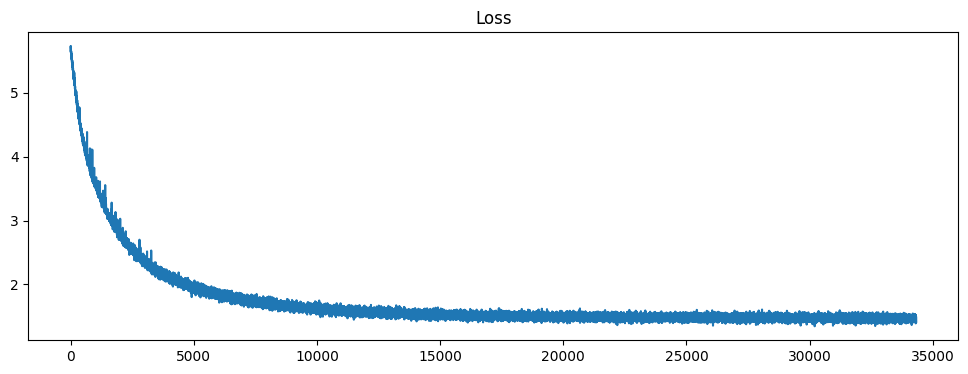

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [105]:
rng_key = jax.random.PRNGKey(128)

In [ ]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
#X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Context window:", block_size)
print("Last context tokens:", test_tokens[-block_size:])

# TODO Autoregressive rollout:
# Feed in test_tokens context window.
# Generate one new token, add to context, dismiss first token in context. The model should now adhere to grammar.
# When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], add it to new_rows.
# Convert the new row into delta values and add to dataframe 
# (here we could do sim: change this row, convert back to tokens, sparse encoding, replace that frame in context for new feed)
# Stop when we have stepped block_size (context window size)
# We should now have a dataframe of new deltas
# TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

#buf, write_pos = generate_sparse(
#    variables,
#    model.apply,
#    test_tokens,   # must end in EOS
#    rng_key,
#    vocab_size=vocab_size,
#    block_size=block_size,
#    max_new_tokens=128,
#    n_channels=n_channels
#)
#generated = buf[block_size:write_pos]

Number of tokens: 7610
Context window: 480
Last context tokens: [  0   2 152   3 153   4 180   5 164   6 106   7 113   8  97   1   0   2
 150   3 151   4 180   5 167   6 106   7 119   8  99   1   0   2 148   3
 151   4 178   5 166   6 106   7 119   8 103   1   0   2 147   3 150   4
 173   5 159   6 111   7 136   8 103   1   0   2 153   3 149   4 168   5
 154   6 124   7 162   8 103   1   0   2 161   3 149   4 168   5 152   6
 125   7 158   8 103   1   0   2 168   3 155   4 171   5 148   6 126   7
 162   8 100   1   0   2 172   3 163   4 169   5 135   6 141   7 154   8
  98   1   0   2 173   3 168   4 166   5 126   6 144   7 141   8  98   1
   0   2 183   3 172   4 169   5 125   6 129   7 141   8  94   1   0   2
 188   3 174   4 169   5 124   6 121   7 145   8  90   1   0   2 185   3
 173   4 166   5 122   6 117   7 145   8  90   1   0   2 178   3 170   4
 170   5 129   6 119   7 158   8  86   1   0   2 171   3 166   4 172   5
 135   6 120   7 167   8  86   1   0   2 170   3 163   4 170

In [25]:
test_tokens

Array([  0,   2, 159, ...,   8, 119,   1], dtype=int32)

In [ ]:
def decode_sparse_row(tokens, n_channels, zero_bin, mids):
    """
    tokens: (L,) sparse token row (BOS ... EOS)
    returns: (D,) delta vector
    """
    D = n_channels
    delta = jnp.full((D,), mids[zero_bin])

    i = 0
    while i < len(tokens):
        tok = tokens[i]

        if tok == 0 or tok == 1:  # BOS / EOS
            i += 1
            continue

        ch = tok - 2
        data = tokens[i + 1] - (2 + n_channels)

        delta = delta.at[ch].set(mids[data])
        i += 2

    return delta

def encode_dense_row_to_sparse(
    x_row,           # (D,)
    prev_x_row,      # (D,)
    edges,
    zero_bin,
    n_channels,
):
    """
    Dense → delta → discretize → sparse tokens
    """
    # delta
    delta = x_row - prev_x_row

    # discretize (global)
    delta_bins = discretize.encode_equal_width_global(
        delta[None, :], edges
    )[0]

    # sparse tokenize
    tokens = tokenizer.encode_with_channels_sparse(
        delta_bins[None, :],
        n_channels,
        zero_bin,
    )

    return tokens

def trim_at_eos(tokens, EOS=1):
    idx = jnp.argmax(tokens == EOS)
    return tokens[:idx + 1]

def extract_last_row(token_stream, write_pos, BOS=0, EOS=1):
    stream = token_stream[:write_pos]

    eos_idx = jnp.max(
        jnp.where(stream == EOS, size=stream.shape[0], fill_value=-1)[0]
    )

    bos_idx = jnp.max(
        jnp.where(stream[:eos_idx] == BOS, size=stream.shape[0], fill_value=-1)[0]
    )

    return stream[bos_idx : eos_idx + 1]
    
def rollout_one_step(
    variables,
    model,
    rng_key,
    token_stream,    # NEW
    write_pos,       # NEW
    last_x,          # (D,)
    prev_x,          # (D,)
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    # encode conditioning row
    #cond_tokens = encode_dense_row_to_sparse(
    #    last_x,
    #    prev_x,
    #    edges,
    #    zero_bin,
    #    n_channels,
    #)
    #print(token_stream[:write_pos])

    # generate next sparse row
    buf, write_pos = generate_sparse(
        variables,
        model.apply,
        token_stream[:write_pos], #cond_tokens,
        rng_key,
        vocab_size=vocab_size,
        block_size=block_size,
        max_new_tokens=max_new_tokens,
        n_channels=n_channels,
    )
    
    token_stream = buf[:write_pos]

    #gen_tokens = buf[block_size:write_pos]
    gen_tokens = extract_last_row(token_stream, write_pos)
    gen_tokens = trim_at_eos(gen_tokens)
    #print(gen_tokens)
    
    # decode to delta
    delta_hat = decode_sparse_row(
        gen_tokens,
        n_channels,
        zero_bin,
        mids,
    )

    # apply delta
    next_x = last_x + delta_hat

    #return next_x, gen_tokens
    return next_x, token_stream, write_pos

def autoregressive_rollout(
    variables,
    model,
    rng_key,
    X_init,          # (T0, D)
    steps,
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    X = [X_init[-1]]
    prev = X_init[-2]

    tokens_out = []

    #token_stream = encode_dense_row_to_sparse(
    #    X_init[-1],
    #    X_init[-2],
    #   edges,
    #    zero_bin,
    #    n_channels,
    #)
    #write_pos = token_stream.shape[0]
    token_rows = []

    for t in range(1, X_init.shape[0]):
        row_tokens = encode_dense_row_to_sparse(
            X_init[t],
            X_init[t - 1],
            edges,
            zero_bin,
            n_channels,
        )
        print(row_tokens)
        token_rows.append(row_tokens)

    token_stream = jnp.concatenate(token_rows)
    write_pos = token_stream.shape[0]

    for _ in tqdm(range(steps)):
        rng_key, sub = jax.random.split(rng_key)

        #next_x, gen_tokens = rollout_one_step(
        next_x, token_stream, write_pos = rollout_one_step(
            variables,
            model,
            sub,
            token_stream,
            write_pos,
            X[-1],
            prev,
            edges,
            mids,
            zero_bin,
            n_channels,
            block_size,
            max_new_tokens,
        )

        prev = X[-1]
        X.append(next_x)
        #gen_tokens = trim_at_eos(extract_last_row(token_stream, write_pos))
        tokens_out.append(gen_tokens)
        
        #token_stream = jnp.concatenate(tokens_out)
        #write_pos = token_stream.shape[0]

    #print(token_stream)
    #print(tokens_out)
    return jnp.stack(X), tokens_out



In [145]:
X_test_nv[-2:]#3:-1]

array([[-0.09510626,  1.4987907 , -0.74665016, -1.8185323 ,  0.9776046 ,
         1.4746351 , -0.37813494],
       [-0.04287379,  1.5603924 , -1.099686  , -1.9422227 ,  1.0232133 ,
         1.6404451 , -0.5956101 ]], dtype=float32)

In [165]:
# last observed dense rows (normalized space)
X_init = jnp.asarray(X_test_nv[-20:])   # shape (2, D)

#print("Initial rows:")
#print(X_init)

X_gen, gen_tokens = autoregressive_rollout(
    variables=variables,
    model=model,
    rng_key=rng_key,
    X_init=X_init,            # (2, D)
    steps=20,                 # rollout horizon
    edges=edges,
    mids=mids,
    zero_bin=ZERO_BIN,
    n_channels=n_channels,
    block_size=block_size,
    max_new_tokens=64,        # per-row cap
)

[  0   2 139   3 134   4 139   5 140   6 138   7 128   8 139   1]
[  0   2 140   3 134   4 128   5 133   6 145   7 142   8 139   1]
[  0   2 138   3 134   4 149   5 149   6 103   7 124   8 134   1]
[  0   2 134   3 136   4 139   5 139   6 136   7 132   8 135   1]
[  0   2 134   3 136   4 127   5 130   8 134   1]
[  0   2 134   3 133   4 147   5 149   6  96   7 124   8 135   1]
[  0   2 135   3 136   4 138   5 139   1]
[  0   2 136   3 136   4 131   5 132   1]
[  0   2 138   3 134   4 144   5 147   8 136   1]
[  0   2 140   3 134   5 140   6 162   7 155   8 139   1]
[  0   2 140   3 140   4 132   5 129   6 163   7 155   8 140   1]
[  0   2 139   3 146   4 139   5 130   6 142   8 138   1]
[  0   2 143   3 145   4 136   5 130   6 143   7 141   8 139   1]
[  0   2 143   3 142   4 131   5 130   6 142   7 141   8 139   1]
[  0   2 139   3 144   4 141   5 136   6 140   7 141   8 135   1]
[  0   3 144   4 134   5 133   6 141   7 154   8 133   1]
[  0   2 134   3 140   4 128   5 132   6 134   7

  0%|          | 0/20 [01:22<?, ?it/s]


TypeError: GPT2_v3.__call__() missing 2 required positional arguments: 'token_types' and 'channel_ids'

In [147]:
for i, t in enumerate(gen_tokens[:5]):
    t_clean = trim_at_eos(t)
    print(f"Step {i} tokens:", t_clean)

Step 0 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 1 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 2 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 3 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 4 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]


In [149]:
X_gen_space = pd.DataFrame(X_gen, columns=X.columns) * sigma + mu
X_gen_space

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,3773.181667,37.400000,8.000000,17.500001,269.999999,16.600000,1005.400000
1,3861.366207,37.977466,5.433047,14.523268,273.548728,17.407109,1004.018589
2,3949.550747,38.554932,2.866094,11.546538,277.097457,18.214218,1002.637179
3,4037.735278,39.132398,0.299140,8.569808,280.646186,19.021328,1001.255768
4,4125.919818,39.709864,-2.267813,5.593078,284.194916,19.828438,999.874357
5,4214.104358,40.287331,-4.834766,2.616347,287.743645,20.635547,998.492947
6,4302.288898,40.864797,-7.401720,-0.360383,291.292374,21.442656,997.111536
7,4390.473438,41.442263,-9.968673,-3.337113,294.841103,22.249766,995.730126
8,4478.657979,42.019729,-12.535626,-6.313843,298.389832,23.056875,994.348715
9,4566.842519,42.597195,-15.102579,-9.290573,301.938561,23.863984,992.967305


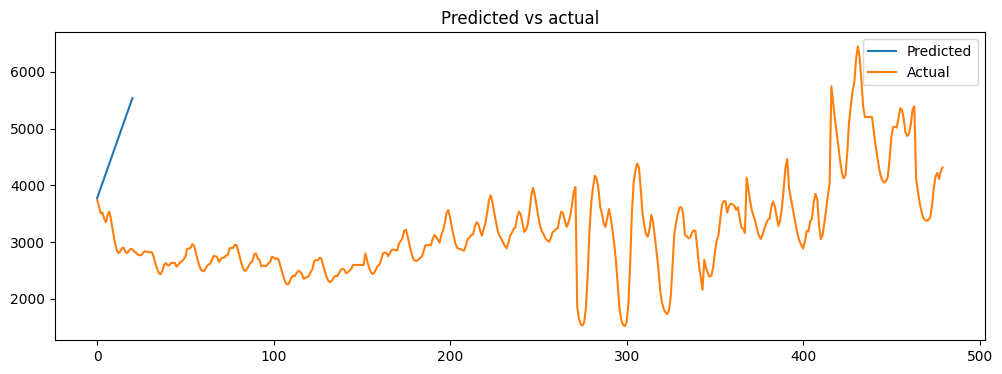

In [150]:
plt.figure(figsize=(12, 4))
plt.plot(X_gen_space.index, X_gen_space['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

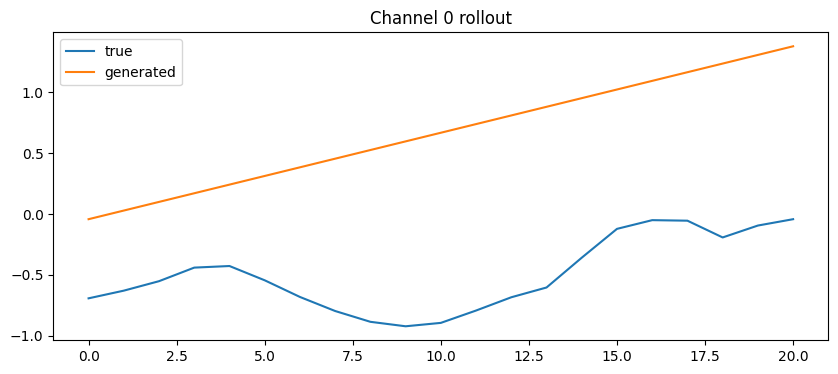

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X_test_nv[-21:, 0], label="true")
plt.plot(X_gen[:, 0], label="generated")
plt.title("Channel 0 rollout")
plt.legend()
plt.show()